In [7]:
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 50)

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from datetime import datetime as dt
import glob
import os

In [8]:
# Setting up file path environment 

os.chdir("/Users/keenansmacbookairm3/Documents/GitHub/the_real_ronald/data/")
os.listdir()

['20240805-021325_page3.json',
 '20240731-204301_page4.json',
 '20240814-021229_page5.json',
 '20240806-141246_page6.json',
 '20240808-141225_page6.json',
 '20240809-081523_page4.json',
 '20240723-081518_page0.json',
 '20240729-021245_page2.json',
 '20240802-081458_page1.json',
 '20240730-203159_page10.json',
 '20240807-021231_page9.json',
 '20240725-141101_page11.json',
 '20240726-021230_page8.json',
 '20240806-141246_page10.json',
 '20240728-141004_page7.json',
 '20240727-081553_page11.json',
 '20240808-021302_page8.json',
 '20240807-141110_page6.json',
 '20240731-021033_page1.json',
 '20240730-141109_page7.json',
 '20240813-203944_page4.json',
 '20240727-204231_page6.json',
 '20240730-021218_page3.json',
 '20240804-081405_page7.json',
 '20240722-110618_page6.json',
 '20240729-203857_page10.json',
 '20240807-081554_page9.json',
 '20240809-141127_page3.json',
 '20240805-203904_page8.json',
 '20240724-203844_page9.json',
 '20240730-081514_page1.json',
 '20240810-141012_page8.json',
 '2

In [9]:
# importing json files

dfs=[]
for file in glob.glob("*.json"):
    dataframe = pd.read_json(file)['posts']
    # flatten the structure
    dataframe = pd.json_normalize(dataframe)
    # insert file names
    dataframe['file_name'] = os.path.basename(file)
    dfs.append(dataframe)

# concatenate all data and drop repeated entries
df=pd.concat(dfs).drop_duplicates(subset='uuid', keep='last')

In [10]:
# slicing out only relevant columns 

selected_columns = [
    'file_name',
    'uuid', 
    'title',
    'content',
    'post_flair_text',
    'author',
    'author_flair_text',
    'created',
    'comments',
    'score_up',
    'preview',
    'link',
    'domain',
    'is_image',
    'is_video',
    'video_link'
    ]	
df = df[selected_columns]

# replace empty cell with Nan
dataframe = dataframe.replace(r'^\s*$', np.nan, regex=True)

# format datetime
df['created'] = pd.to_datetime(df.created, unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
# crate a column storing "date" 
df['created_date'] = df['created'].dt.date
df['created_date'] = df['created_date'].astype(str)


# fix empty or ill-formed domain column
selfpost_mask = df.domain.str.match('^$')
df.loc[selfpost_mask, 'domain'] = 'self_post'

df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 14319 entries, 2 to 24
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype                     
---  ------             --------------  -----                     
 0   file_name          14319 non-null  object                    
 1   uuid               14319 non-null  object                    
 2   title              14319 non-null  object                    
 3   content            14319 non-null  object                    
 4   post_flair_text    14319 non-null  object                    
 5   author             14319 non-null  object                    
 6   author_flair_text  14319 non-null  object                    
 7   created            14319 non-null  datetime64[ns, US/Eastern]
 8   comments           14319 non-null  int64                     
 9   score_up           14319 non-null  int64                     
 10  preview            14319 non-null  object                    
 11  link               1431

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_17377/2861381519.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe = dataframe.replace(r'^\s*$', np.nan, regex=True)


In [11]:
# Unpack shortened domains
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import tldextract

common_shorts = [
    "adf.ly", "adfoc.us", "amzn.to", "atominik.com", "ay.gy", "b.link", "bhpho.to", "bit.ly", "bit.do", 
    "bn.gy", "branch.io", "buff.ly", "ceesty.com", "chollo.to", "cli.re", "cli.fm", "cutt.ly", "cutt.us", 
    "db.tt", "f.ls", "fa.by", "fb.me", "flip.it", "fumacrom.com", "git.io", "geni.us", "goo.gl", "gns.io", 
    "hmm.rs", "ht.ly", "hyperurl.co", "ity.im", "intamema.com", "is.gd", "j.gs", "j.mp", "kutt.it", "ldn.im", 
    "linklyhq.com", "microify.com", "mzl.la", "nmc.sg", "nowlinks.net", "ow.ly", "prf.hn", "plu.sh", "q.gs", 
    "qr.ae", "qr.net", "rebrand.ly", "rb.gy", "rlu.ru", "rotf.lol", "s.coop", "s.id", "sh.st", "soo.gd", 
    "shortcm.xyz", "short.gy", "shortcm.xyz", "shorturl.at", "smu.sg", "smq.tc", "snip.ly", "snipr.com", 
    "snipurl.com", "snurl.com", "split.to", "surl.li", "t.co", "t.ly", "t2m.io", "tiny.cc", "tiny.pl", 
    "tinyium.com", "tinyurl.com", "tiny.one", "tny.im", "tny.sh", "tr.im", "trib.al", "u.to", "v.gd", 
    "virg.in", "vzturl.com", "waa.ai", "washex.am", "x.co", "y2u.be", "yourwish.es", "zpr.io", "1url.com", 
    "2.gp", "3.ly", "4sq.com", "6url.com", "7.ly", "9.bb", "amp.gs", "atz.bz", "binged.it",
    "budurl.com", "cort.as", "decenturl.com", "dft.ba", "goo.gl", "inbound.org", "itsh.bo", "mcaf.ee",
    "n.pr", "nyti.ms", "on.fb.me", "prsm.tc", "redd.it", "tnw.to", "twt.fi", "u.nu", "virl.io", "wapo.st",
    "wp.me", "xrl.us",  "zurl.ws", "dlvr.it", 'msft.it', "lnkd.in ", 'spr.ly', 'rebelne.ws', 'scroll.in', 'ab.co',
    'hubs.li', 'bbc.in', 'nature.ly', 'cbsn.ws' , 'brnw.ch', 'youtu.be'
                ]

# Set up a Requests session with retries
session = requests.Session()
headers = {
    'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.5',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
    'DNT': '1',
    'referer': 'https://www.google.com/'
}

headers = {
        'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
        'referer':'https://google.com',
        'DNT':'1'
    }

# session.headers.update(headers)
retries = Retry(total=4, backoff_factor=1, status_forcelist=[502, 503, 504])
session.mount('http://', HTTPAdapter(max_retries=retries))
session.mount('https://', HTTPAdapter(max_retries=retries))

def check_connection(host='http://www.google.com'):
    try:
        session.get(host, timeout=1)
        return True
    except (requests.ConnectionError, requests.Timeout):
        return False

def wait_for_connection(interval=30, max_attempts=10):
    attempts = 0
    while not check_connection() and attempts < max_attempts:
        time.sleep(interval)
        attempts += 1
    return attempts < max_attempts

def resolve_url_head(short_url):
    if not wait_for_connection():
        raise ConnectionError("Internet connection could not be re-established.")
    try:
        response = requests.head(short_url, allow_redirects=True, timeout=1)
        return response.url if response.status_code == 200 else short_url
    except requests.RequestException:
        return short_url
    
def resolve_url_get(short_url):
    if not wait_for_connection():
        raise ConnectionError("Internet connection could not be re-established.")
    try:
        response = session.get(short_url, allow_redirects=True, timeout=5)
        return response.url if response.status_code == 200 else short_url
    except requests.RequestException:
        return short_url
    if not wait_for_connection():
        raise ConnectionError("Internet connection could not be re-established.")
    try:
        response = session.get(url=shortend_url, allow_redirects=True, timeout=1)        
   
    except requests.RequestException:
        return None    
    
df['domain'] = df['domain'].apply(lambda x: tldextract.extract(x).domain + "." + tldextract.extract(x).suffix if x != 'self_post' else 'self_post')
short_mask = df['domain'].isin(common_shorts)
df.loc[short_mask, 'domain'] = df.loc[short_mask, 'link'].apply(lambda x: resolve_url_get(x)).apply(lambda x: tldextract.extract(x).domain + "." + tldextract.extract(x).suffix)

In [12]:
# The top 10 most-shared domains on The Ronald's landing page
df.domain.value_counts(normalize=True).head(10)

domain
twitter.com             0.373280
scored.co               0.268804
patriots.win            0.169076
self_post               0.034011
thegatewaypundit.com    0.017599
youtube.com             0.015294
videy.co                0.008590
zerohedge.com           0.007682
rumble.com              0.006704
breitbart.com           0.006565
Name: proportion, dtype: float64

In [13]:
# Number of posts in our datasets by date
df.value_counts('created_date').sort_index()

created_date
2024-07-21     62
2024-07-22    576
2024-07-23    615
2024-07-24    599
2024-07-25    620
2024-07-26    586
2024-07-27    629
2024-07-28    623
2024-07-29    646
2024-07-30    581
2024-07-31    622
2024-08-01    582
2024-08-02    624
2024-08-03    636
2024-08-04    635
2024-08-05    647
2024-08-06    614
2024-08-07    584
2024-08-08    608
2024-08-09    604
2024-08-10    585
2024-08-11    622
2024-08-12    674
2024-08-13    605
2024-08-14    140
Name: count, dtype: int64

In [14]:
# Due to the lack of data, removing all posts from 2024-07-21

df = df[df['created_date'] != '2024-07-21']

df.value_counts('created_date').sort_index()

created_date
2024-07-22    576
2024-07-23    615
2024-07-24    599
2024-07-25    620
2024-07-26    586
2024-07-27    629
2024-07-28    623
2024-07-29    646
2024-07-30    581
2024-07-31    622
2024-08-01    582
2024-08-02    624
2024-08-03    636
2024-08-04    635
2024-08-05    647
2024-08-06    614
2024-08-07    584
2024-08-08    608
2024-08-09    604
2024-08-10    585
2024-08-11    622
2024-08-12    674
2024-08-13    605
2024-08-14    140
Name: count, dtype: int64

In [15]:
# keep only the top 500 posts by "score_up" from each date so that the playing field is more leveled
df = df.groupby('created_date').apply(lambda x: x.nlargest(500, 'score_up')).reset_index(drop=True)

df.value_counts("created_date").sort_index()

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_17377/1084774859.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('created_date').apply(lambda x: x.nlargest(500, 'score_up')).reset_index(drop=True)


created_date
2024-07-22    500
2024-07-23    500
2024-07-24    500
2024-07-25    500
2024-07-26    500
2024-07-27    500
2024-07-28    500
2024-07-29    500
2024-07-30    500
2024-07-31    500
2024-08-01    500
2024-08-02    500
2024-08-03    500
2024-08-04    500
2024-08-05    500
2024-08-06    500
2024-08-07    500
2024-08-08    500
2024-08-09    500
2024-08-10    500
2024-08-11    500
2024-08-12    500
2024-08-13    500
2024-08-14    140
Name: count, dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11640 entries, 0 to 11639
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype                     
---  ------             --------------  -----                     
 0   file_name          11640 non-null  object                    
 1   uuid               11640 non-null  object                    
 2   title              11640 non-null  object                    
 3   content            11640 non-null  object                    
 4   post_flair_text    11640 non-null  object                    
 5   author             11640 non-null  object                    
 6   author_flair_text  11640 non-null  object                    
 7   created            11640 non-null  datetime64[ns, US/Eastern]
 8   comments           11640 non-null  int64                     
 9   score_up           11640 non-null  int64                     
 10  preview            11640 non-null  object                    
 11  link           

In [17]:
# extracting twitter handles 
df[df.domain =='twitter.com'].link.str.split('/').str[3].str.lower()
df.loc[df.domain == 'twitter.com', 'twitter_handle'] = df[df.domain == 'twitter.com'].link.str.split('/').str[3].str.lower()
df['twitter_handle'].fillna(np.nan, inplace=True)

# top twitter handles mentioned
df.value_counts('twitter_handle', ascending=False).head(10)

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_17377/2627713672.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['twitter_handle'].fillna(np.nan, inplace=True)


twitter_handle
elonmusk           168
behizytweets       156
endwokeness         90
libsoftiktok        79
dc_draino           78
rncresearch         77
immeme0             71
bennyjohnson        62
catturd2            59
trobinsonnewera     56
Name: count, dtype: int64

In [18]:
import spacy
from nltk import bigrams, trigrams
nlp = spacy.load('en_core_web_lg')
stopwords = list(nlp.Defaults.stop_words)


import contractions
import emoji
import re
from tqdm import tqdm
tqdm.pandas()


def clean_it_all_up (text):
    text = emoji.replace_emoji(text)
    text = contractions.fix(text)
    text = re.sub(r'\W+', ' ', text)
    doc = nlp(text)
    lemmatized_tokens = []
    
    for token in doc:
        if (
            token.text.lower() not in stopwords
            # and token.pos_ in {'NOUN', 'PROPN', 'VERB', 'ADJ'} 
            # and token.ent_type_ not in {'GPE', 'LOC'}
            and token.pos_ not in {"AUX","CONJ", "CCONJ", "DET", "INTJ", "PART", "PUNCT", "SYM", "X", "SPACE"}
        ):
          
            
            lemmatized_tokens.append(token.lemma_.lower())
            
    return " ".join(lemmatized_tokens)   

In [19]:
def date_selection(start_date, end_date):
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")

    date_list = []
    current_date = start_date
    date_list.append(current_date.strftime('%Y-%m-%d'))

    while current_date < end_date:
        next_date = current_date + datetime.timedelta(days=1)
        next_date = next_date
        if next_date >= end_date:
            next_date = end_date
        date_list.append(next_date.strftime('%Y-%m-%d'))
        current_date = next_date

    return date_list


In [20]:
def ngram_generator(num, start_date, end_date, top_n=None):
    
    date_list = date_selection(start_date, end_date)

    cleaned_tokens = ' '.join(df[df.created_date.isin(date_list)]['title'].apply(clean_it_all_up).tolist())
    if num == 1:
        ngram = pd.Series(cleaned_tokens.split()).value_counts()
    elif num == 2:
        ngram = pd.Series(list(bigrams(cleaned_tokens.split()))).value_counts()
    elif num == 3:
        ngram = pd.Series(list(trigrams(cleaned_tokens.split()))).value_counts()
    else:
        raise ValueError('Invalid number. Must choose between 1, 2, or 3.')
    
    ngram = ngram[ngram > 1].head(top_n)
    return ngram


In [22]:
# function of returning top ngrams from the past 24 hours

def ngram_generator_24hrs(num, top_n=None):
    # Get current time and time 24 hours ago
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=1)
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")
    
    return  ngram_generator(num, start_date, end_date, top_n)

In [23]:
# function of returning top ngrams from the past 7 days

def ngram_generator_7days(num, top_n=None):
    # Get current time and time 24 hours ago
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=7)
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")
    
    return ngram_generator(num, start_date, end_date, top_n)

In [24]:
# creating a function to return a wordcloud chart covering a specific period of dates
from wordcloud import WordCloud

def ngram_cloud(num, start_date, end_date, top_n=None):
    ngram = ngram_generator(num=num, start_date=start_date, end_date=end_date, top_n=top_n)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white').\
    generate_from_frequencies(words_cloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

In [138]:
# creating a function to return a wordcloud chart covering ONLY the past 24 hours

def ngram_24hrs_cloud(num, save_viz, top_n=None):
    ngram = ngram_generator_24hrs(num, top_n=None)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white').\
    generate_from_frequencies(words_cloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, 
               interpolation='nearest',
               aspect="auto"
               )
    plt.title(f"Top {top_n} bigrams in the last 24 hours",
              fontsize=20,
              pad=25,
              )
    plt.axis('off')

    if save_viz is not None:
        os.chdir("/Users/keenansmacbookairm3/Documents/GitHub/the_real_ronald/visualizations/")
        plt.savefig(f"{save_viz}.jpeg",
                    dpi=600,
                    
                    )
    else:
        plt.show()

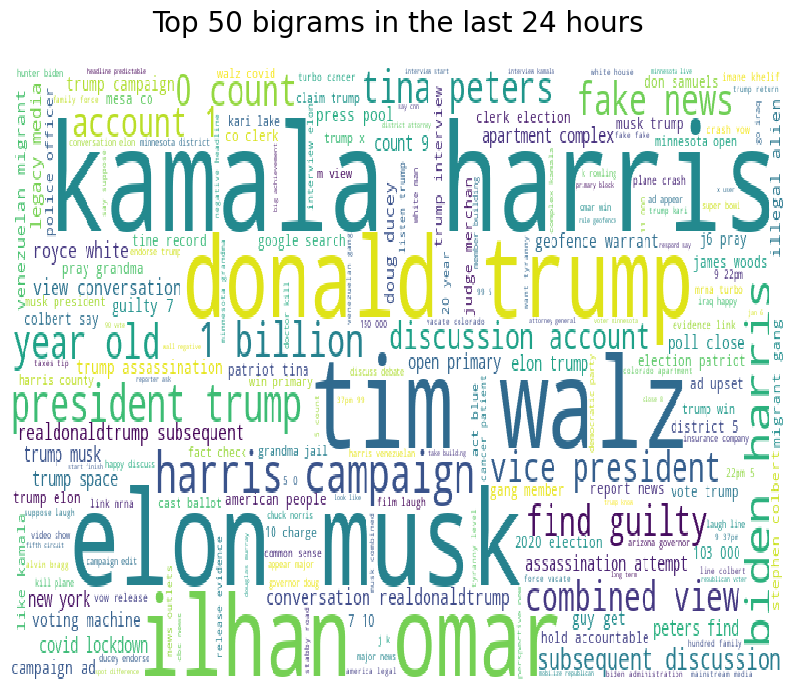

In [139]:
# creating and saving the top 50 bigrams from the last 24 hours

num = 2
top_n = 50
save_viz = 'bigrams_wordcloud_24hrs'
ngram_24hrs_cloud(num, top_n=top_n, save_viz=save_viz)


In [81]:
# creating a function to return a wordcloud chart covering ONLY the past 7 days


def ngram_7days_cloud(num, save_viz, top_n=None):
    ngram = ngram_generator_7days(num, top_n=None)
    words_cloud = pd.DataFrame(ngram, columns=['count']).reset_index().rename(columns={'index': 'phrases'})
    words_cloud['phrases'] = words_cloud['phrases'].apply(lambda x: ', '.join(x) if isinstance(x,tuple) else x)
    words_cloud['phrases'] = words_cloud['phrases'].str.replace(',', '')
    wordcloud = WordCloud(width=800, height=400, background_color='white').\
    generate_from_frequencies(words_cloud.set_index('phrases')['count'].to_dict())
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    if save_viz is not None:
        os.chdir("/Users/keenansmacbookairm3/Documents/GitHub/the_real_ronald/visualizations/")
        plt.savefig(save_viz + '.jpeg', dpi=600)
    else:
        plt.show()

In [54]:
# A summary table of authors based on a given date
def top_acounts(start_date, end_date, top_n=None):
    date_list = date_selection(start_date, end_date)
    top_authors = df[df['created_date'].isin(date_list)]['author'].value_counts().reset_index()
    top_authors = top_authors[top_authors['count']>1]
    comments_total = df.groupby('author').comments.sum()
    upvotes_total = df.groupby('author').score_up.sum()
    top_authors =  top_authors.merge(comments_total, on='author').merge(upvotes_total, on='author')
    top_authors = top_authors.rename(columns={
                                        'author': 'top_authors',
                                        'count' : 'posts',
                                        'comments': 'accumulated_comments',
                                        'score_up': 'accumulated_upvotes'
                                        })
    top_authors = top_authors.sort_values('posts', ascending=False).head(top_n)
    return  top_authors

In [55]:
# This function returns the most posted domains from a specific period of time

def top_domains(start_date, end_date, top_n=None):
    date_list = date_selection(start_date, end_date)
    top_urls = df[df['created_date'].isin(date_list)]['domain'].value_counts(dropna=False, normalize=True).head(top_n)
    return top_urls

In [57]:
# This function returns the most posted domains from the last 7 days

def top_domains_7days(top_n=None):
    end_date = datetime.datetime.now()
    start_date = end_date - datetime.timedelta(days=7)
    
    start_date = start_date.strftime("%Y-%m-%d")
    end_date = end_date.strftime("%Y-%m-%d")

    date_list = date_selection(start_date, end_date)
    top_urls = df[df['created_date'].isin(date_list)]['domain'].value_counts(dropna=False, normalize=True).head(top_n)
    return top_urls

In [62]:
# Popular Twitter accounts on The Ronald

def top_xitter(start_date, end_date, top_n=None):
    date_list = date_selection(start_date, end_date)
    xiter_accounts = df[(df.link.str.contains('twitter.com'))& (df['created_date'].isin(date_list))]
    top_xitter = xiter_accounts['link'].str.split('/').str[3].str.lower().value_counts(normalize=False, dropna=False).head(top_n)
    return top_xitter

In [343]:
df.groupby(['author', 'twitter_handle'])['twitter_handle'].value_counts().sort_values(ascending=False).head(10)

author               twitter_handle
DeusVult1096         behizytweets      33
Trump_Is_My_Daddy    elonmusk          22
Mr_Rightside         behizytweets      21
I-am-Orlando         behizytweets      20
PiratePatriotParrot  behizytweets      16
MickHigan2           i                 16
Patriotsrock4ever    i                 15
Tcrussell            behizytweets      15
kinbergfan           julie_kelly2      14
Trump_Is_My_Daddy    dc_draino         13
Name: count, dtype: int64

In [65]:
# a ngram generator that returns date-based

def new_ngram_generator(num, start_date, end_date, top_n=None):
    # Filter dates
    date_list = date_selection(start_date, end_date)
    
    # Filter and process data
    filtered_df = df[df.created_date.isin(date_list)]
    filtered_df['cleaned_title'] = filtered_df['title'].apply(clean_it_all_up)
    
    ngrams_with_dates = []
    
    for index, row in filtered_df.iterrows():
        tokens = row['cleaned_title'].split()
        if num ==1:
            unigrams_list = list(tokens)
            for unigram in unigrams_list:
                ngrams_with_dates.append((unigram, row['created_date']))
        elif num == 2:
            bigrams_list = list(bigrams(tokens))
            for bigram in bigrams_list:
                ngrams_with_dates.append((bigram, row['created_date']))
        elif num == 3:
            trigrams_list = list(trigrams(tokens))
            for trigram in trigrams_list:
                ngrams_with_dates.append((trigram, row['created_date']))
        else:
            raise ValueError('Invalid number. Must choose between 2 or 3.')
    
    ngram_df = pd.DataFrame(ngrams_with_dates, columns=['ngram', 'date']).head(top_n)
    return ngram_df


In [66]:
new_ngram_generator(1, '2024-08-10', '2024-08-13', top_n=None)

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_17377/2655735208.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cleaned_title'] = filtered_df['title'].apply(clean_it_all_up)


,ngram,date
0,elon,2024-08-10
1,musk,2024-08-10
2,understand,2024-08-10
3,resistance,2024-08-10
4,report,2024-08-10
...,...,...
17732,english,2024-08-13
17733,word,2024-08-13
17734,american,2024-08-13
17735,vs,2024-08-13


In [73]:
def ngram_time_series(num, start_date, end_date, save_viz, top_n=None, ):

    ngrams_df = new_ngram_generator(num=num, start_date=start_date, end_date=end_date, top_n=None)

    ngrams_df['date'] = pd.to_datetime(ngrams_df['date'])

    ngrams_counts = ngrams_df.groupby([ngrams_df['date'].dt.to_period('d'), 'ngram']).size().reset_index(name='count')

    top_ngrams = ngrams_counts.groupby('ngram')['count'].sum().nlargest(top_n).index

    top_ngrams_counts = ngrams_counts[ngrams_counts['ngram'].isin(top_ngrams)]

    top_ngram_pivot = top_ngrams_counts.pivot(index='date', columns='ngram', values='count').fillna(0)

    top_ngram_pivot.index = top_ngram_pivot.index.to_timestamp()

    plt.figure(figsize=(10, 8))


    top_ngram_plot = sns.lineplot(data=top_ngram_pivot)

    plt.xlabel('')
    plt.ylabel('Mention count')
    plt.title(f'Top bigrams on the landing page of The Ronald between {start_date} and {end_date}')

    plt.xticks(rotation=45) 
    plt.grid(True)

    plt.legend(title='Top Bigrams', bbox_to_anchor=(1.3, 1), loc='upper right')
    
    if save_viz is not None:
        os.chdir("/Users/keenansmacbookairm3/Documents/GitHub/the_real_ronald/visualizations/")
        plt.savefig(save_viz + '.jpeg', dpi=600)
    else:
        plt.show()

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_17377/2655735208.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cleaned_title'] = filtered_df['title'].apply(clean_it_all_up)


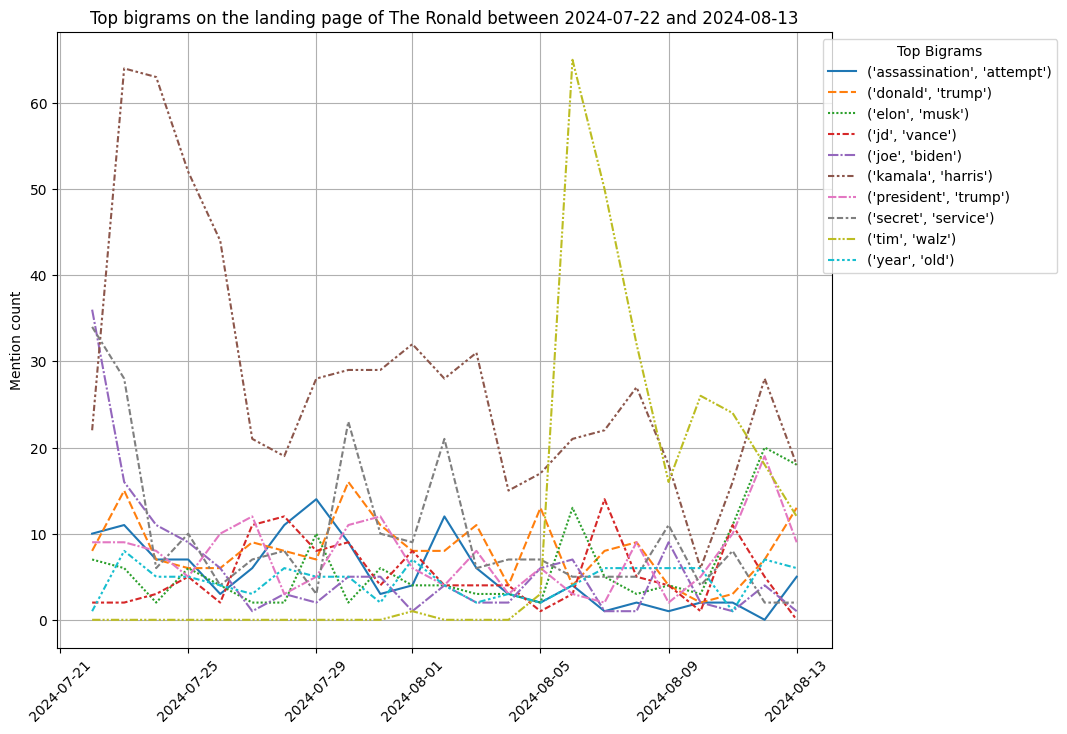

In [74]:
num = 2
start_date = '2024-07-22'
end_date='2024-08-13'
top_n = 10
save_viz=None
ngram_time_series (num=num, start_date=start_date, end_date=end_date, top_n=top_n, save_viz=save_viz)

In [75]:
# create interactive charts with Plotly

import plotly.graph_objs as go

def ngram_time_series_interactive(num, start_date, end_date, save_viz, top_n=None):
    ngrams_df = new_ngram_generator(num=num, start_date=start_date, end_date=end_date, top_n=None)

    ngrams_df['date'] = pd.to_datetime(ngrams_df['date'])

    ngrams_counts = ngrams_df.groupby([ngrams_df['date'].dt.to_period('d'), 'ngram']).size().reset_index(name='count')

    top_ngrams = ngrams_counts.groupby('ngram')['count'].sum().nlargest(top_n).index

    top_ngrams_counts = ngrams_counts[ngrams_counts['ngram'].isin(top_ngrams)]

    top_ngram_pivot = top_ngrams_counts.pivot(index='date', columns='ngram', values='count').fillna(0)

    top_ngram_pivot.index = top_ngram_pivot.index.to_timestamp()

    fig = go.Figure()

    for ngram in top_ngram_pivot.columns:
        fig.add_trace(go.Scatter(
            x=top_ngram_pivot.index, 
            y=top_ngram_pivot[ngram], 
            mode='lines', 
            name=str(ngram)))

    fig.update_layout(
        width=1400,
        height=800,
        title=f'Top bigrams on the landing page of The Ronald between {start_date} and {end_date}',
        xaxis_title='Date',
        yaxis_title='Mention count',
        xaxis=dict(tickangle=45),
        legend_title_text='Top Bigrams'
    )


    if save_viz is not None:
        os.chdir("/Users/keenansmacbookairm3/Documents/GitHub/the_real_ronald/visualizations/")
        fig.savefig(save_viz + '.jpeg', dpi=600)
    else:
        fig.show()

In [87]:
# This function would only cover the past n days

def ngram_time_last_n_days_interactive(num, last_ndays, top_n=None):
    end_date = pd.to_datetime(df['created_date'].max())
    start_date = end_date - pd.Timedelta(days=last_ndays)
    start_date= start_date.strftime("%Y-%m-%d")
    end_date= end_date.strftime("%Y-%m-%d")

    ngrams_df = new_ngram_generator(num=num, start_date=start_date, end_date=end_date, top_n=None)

    ngrams_df['date'] = pd.to_datetime(ngrams_df['date'])
    ngrams_counts = ngrams_df.groupby([ngrams_df['date'].dt.to_period('d'), 'ngram']).size().reset_index(name='count')
    
    top_ngrams = ngrams_counts.groupby('ngram')['count'].sum().nlargest(top_n).index
    top_ngrams_counts = ngrams_counts[ngrams_counts['ngram'].isin(top_ngrams)]

    top_ngram_pivot = top_ngrams_counts.pivot(index='date', columns='ngram', values='count').fillna(0)
    top_ngram_pivot.index = top_ngram_pivot.index.to_timestamp()


    y_max=top_ngram_pivot.values.max()
    y_range=[0, y_max * 1.1]

    fig = go.Figure()

    for ngram in top_ngram_pivot.columns:
        fig.add_trace(go.Scatter(
            x=top_ngram_pivot.index, 
            y=top_ngram_pivot[ngram], 
            mode='lines', 
            name=str(ngram)))
        
    fig.update_traces(line={'width': 5})

    fig.update_layout(
        width=1200,
        height=800,
        title=f'Top bigrams on the landing page of The Ronald between {start_date} and {end_date}',
        xaxis=dict(title='Date',
                   tickangle=45), 
        yaxis=dict(title='Mention count', 
                   range=y_range),
        legend_title_text='Top Bigrams'
)

    fig.show()

In [165]:
# This function would only cover the past 7 days

def ngram_time_last_7_days_interactive(num, save_viz, top_n=None):
    end_date = pd.to_datetime(df['created_date'].max())
    start_date = end_date - pd.Timedelta(days=7)
    start_date= start_date.strftime("%Y-%m-%d")
    end_date= end_date.strftime("%Y-%m-%d")

    ngrams_df = new_ngram_generator(num=num, start_date=start_date, end_date=end_date, top_n=None)

    ngrams_df['date'] = pd.to_datetime(ngrams_df['date'])
    ngrams_counts = ngrams_df.groupby([ngrams_df['date'].dt.to_period('d'), 'ngram']).size().reset_index(name='count')
    
    top_ngrams = ngrams_counts.groupby('ngram')['count'].sum().nlargest(top_n).index
    top_ngrams_counts = ngrams_counts[ngrams_counts['ngram'].isin(top_ngrams)]

    top_ngram_pivot = top_ngrams_counts.pivot(index='date', columns='ngram', values='count').fillna(0)
    top_ngram_pivot.index = top_ngram_pivot.index.to_timestamp()


    y_max=top_ngram_pivot.values.max()
    y_range=[0, y_max * 1.1]

    fig = go.Figure()

    for ngram in top_ngram_pivot.columns:
        fig.add_trace(go.Scatter(
            x=top_ngram_pivot.index, 
            y=top_ngram_pivot[ngram], 
            mode='lines', 
            name=str(ngram)))
        
    fig.update_traces(line={'width': 5})

    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', name=' ', showlegend=True))


    fig.update_layout(
        width=1200,
        height=800,
        title = dict(
            text = f'Top bigrams on the landing page of The Ronald between {start_date} and {end_date}',
            font = dict(family = "Ariel", 
                        size = 30),
            pad=dict(t=20)
        ),
        xaxis=dict(title='Date',
                   tickangle=45), 
        yaxis=dict(title='Mention count', 
                   range=y_range),
        legend_title = dict(
            text= '<b>Top Bigrams<br>(try cliking these variables)</b>',
            font = dict(family = "Courier", 
                        color= 'firebrick',
                        size = 15),
        )
      
)
    
    if save_viz is not None:
        os.chdir("/Users/keenansmacbookairm3/Documents/GitHub/the_real_ronald/visualizations/")
        fig.write_html(f"{save_viz}.html")
        fig.show()

    else:
        fig.show()


In [166]:
num=2
top_n=10
save_viz = "interactive_bigrams_7days"
ngram_time_last_7_days_interactive(num=num, save_viz=save_viz, top_n=top_n)

/var/folders/f2/xbsrplkj23z71l_fw6890_hr0000gn/T/ipykernel_17377/2655735208.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

